# GEQIE OQIM Example

## Setup

### Imports

In [1]:
import numpy as np
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import geqie
from geqie.encodings import oqim

## Encoding

### Opening the image

In [2]:
image = Image.open("../assets/rgb4x4.png")
image = ImageOps.grayscale(image)
image = np.asarray(image)
image

array([[ 76,  76, 150, 226],
       [ 76, 226, 226,  75],
       [105,  29, 255, 119],
       [ 15,  15,   0,   0]], dtype=uint8)

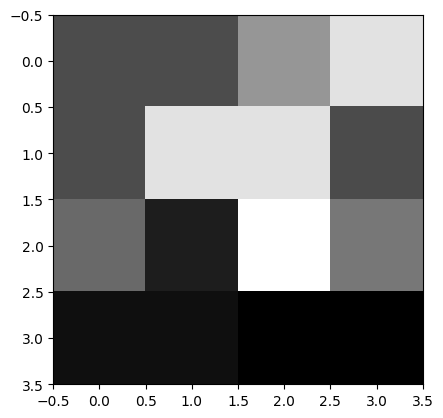

In [3]:
plt.imshow(image, cmap='gray')

### Encoding using unitary gate

OQIM method uses:
1. For color encoding the same procedure as FRQI. Please see frqi.ipynb for details.
2. Pixel position is encoded with using angle. Such that $\ket{0}$ defines first pixel, and $\ket{1}$ the last one pixel:

The order of pixels is as follows:

$
\begin{bmatrix}
0 & 1 & 2 & \cdots & 2^n-1 \\
2^n & 2^n+1 & 2^n+2 & \cdots & 2^{n+1}-1 \\
\vdots & \vdots & \vdots & \cdots & \vdots \\
\vdots & \vdots & \vdots & \cdots & \vdots \\
2^{2n-1} & 2^{2n-1}+1 & 2^{2n-1}+2 & \cdots & 2^{2n}-1 \\
\end{bmatrix}
$

Total amount of qubits required for OQIM is $log_2(image\_width) + log_2(image\_height) + 2$. 

Extra two qubits are required for rotary operator, consist of two $R_y$ gates:

$R_{c,i} = R_y(\theta) \otimes \ket{0}\bra{0}$

$R_{p,i} = R_y(\phi) \otimes \ket{1}\bra{1}$

Where $\theta$ stays for color encoding, and $\phi$ stays for position encoding.

The total operator is presented:

$$R_{cp,i} = \left( I^{\otimes 2} \otimes \sum_{\substack{j=0, j \neq i}}^{2^{2n}-1} \ket{j}\bra{j} \right) + R_i \otimes \ket{i}\bra{i}$$

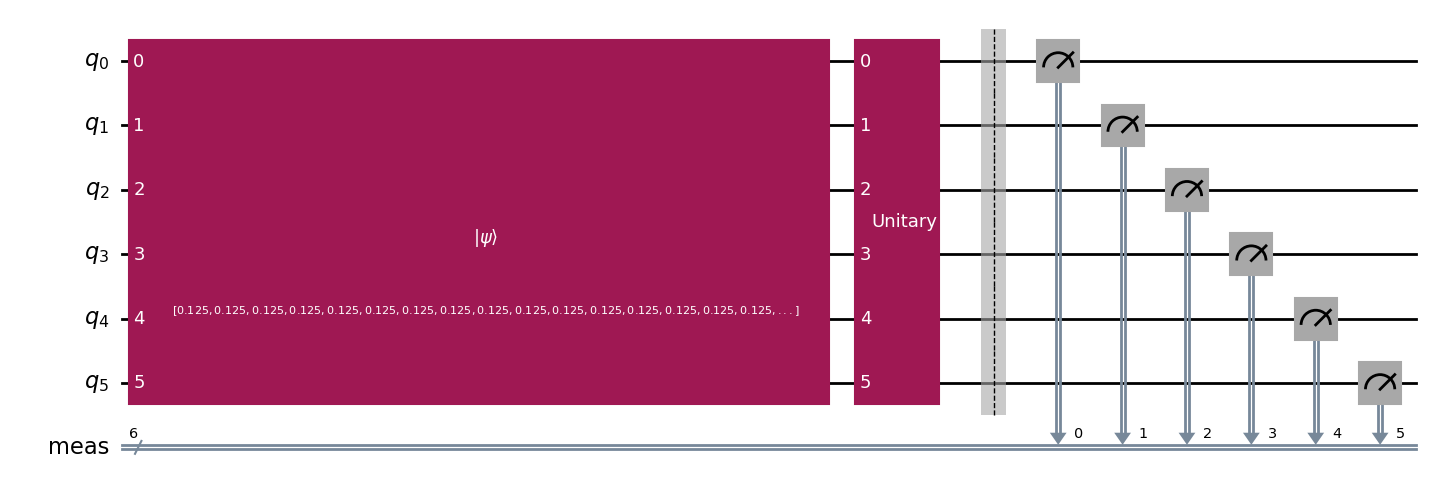

In [4]:
circuit = geqie.encode(oqim.init_function, oqim.data_function, oqim.map_function, image)
circuit.draw(output='mpl')

### Simulating the circuit

In [5]:
result = geqie.simulate(circuit, 10000, return_padded_counts=True)
result = {key: result[key] for key in sorted(result)}
result

{'000000': 59,
 '000001': 0,
 '000010': 269,
 '000011': 310,
 '000100': 60,
 '000101': 3,
 '000110': 234,
 '000111': 299,
 '001000': 198,
 '001001': 10,
 '001010': 120,
 '001011': 289,
 '001100': 339,
 '001101': 39,
 '001110': 6,
 '001111': 267,
 '010000': 50,
 '010001': 43,
 '010010': 237,
 '010011': 274,
 '010100': 284,
 '010101': 83,
 '010110': 10,
 '010111': 254,
 '011000': 309,
 '011001': 120,
 '011010': 15,
 '011011': 205,
 '011100': 69,
 '011101': 140,
 '011110': 226,
 '011111': 176,
 '100000': 113,
 '100001': 197,
 '100010': 216,
 '100011': 136,
 '100100': 13,
 '100101': 213,
 '100110': 306,
 '100111': 105,
 '101000': 312,
 '101001': 251,
 '101010': 0,
 '101011': 72,
 '101100': 127,
 '101101': 254,
 '101110': 164,
 '101111': 56,
 '110000': 3,
 '110001': 295,
 '110010': 278,
 '110011': 27,
 '110100': 3,
 '110101': 292,
 '110110': 336,
 '110111': 16,
 '111000': 0,
 '111001': 303,
 '111010': 316,
 '111011': 4,
 '111100': 0,
 '111101': 305,
 '111110': 290,
 '111111': 0}

## Retrieving the image


For each measured state, we distinguish 4 sub-states such that:
- $\ket{xx..x00}$ - determines that the measured pixel is bright;
- $\ket{xx..x01}$ - determines that the measured pixel position is firstone;
- $\ket{xx..x10}$ - determines that the measured pixel is dark;
- $\ket{xx..x11}$ - determines that the measured pixel position is lastone;


For detailed procedure, please see code below:

In [6]:
retrived_image = np.zeros_like(image)

# pixel_id_vector = |00> |01> |10> |11>
# |00>, |10> - color
# |01>, |11> - pixel coordinate
# Map: np.kron(identity_gate, ket_bra_0), Data: '0000': 633,  '0001': 0,   '0010': 631, '0011': 1235
# Data: np.kron(identity_gate, ket_bra_1), Map: '0000': 1185, '0001': 620, '0010': 0,   '0011': 634

# Map: np.kron(identity_gate, ket_bra_0), Data: '01': 0,  '11': 1235
# Data: np.kron(identity_gate, ket_bra_1), Map: '00': 1185, '10': 0,

pixel_pos_vector_one = np.zeros(image.shape[0]*image.shape[1])
pixel_pos_vector_total = np.zeros(image.shape[0]*image.shape[1])

pixel_col_vector_one = np.zeros(image.shape[0]*image.shape[1])
pixel_col_vector_total = np.zeros(image.shape[0]*image.shape[1])

for state, n in result.items():  
    pixel_id = int(state[:-2], base=2)

    xy_qubit = state[-2:]
    
    if xy_qubit == '11':
        pixel_pos_vector_one[pixel_id] = n
    if xy_qubit == '01' or xy_qubit == '11':
        pixel_pos_vector_total[pixel_id] += n    
    if xy_qubit == '00':
        pixel_col_vector_one[pixel_id] = n
    if xy_qubit == '00' or xy_qubit == '10':
        pixel_col_vector_total[pixel_id] += n

In [7]:
# Colors are in range: 0.0 to 1.0
pixel_col_vec = np.array(pixel_col_vector_one/pixel_col_vector_total)
# Positions are in range: 0.0 to 1.0. Where pixel at the position 00..0 is 0.0, and pixel at the position 11..1 is 1.0
pixel_pos_vec = np.array(pixel_pos_vector_one/pixel_pos_vector_total)

pixel_pos_col_array = np.stack((pixel_col_vec, pixel_pos_vec))
sorted_indices = np.argsort(pixel_pos_col_array[1, :])[::-1]
sorted_array = pixel_pos_col_array[:, sorted_indices]

retrived_image = sorted_array[0].reshape((image.shape[0], image.shape[1]))
    
print('\nOriginal image:')
print(image)
print('Retrived image:')
print(f"{retrived_image}")


Original image:
[[ 76  76 150 226]
 [ 76 226 226  75]
 [105  29 255 119]
 [ 15  15   0   0]]
Retrived image:
[[0.17987805 0.20408163 0.62264151 0.9826087 ]
 [0.17421603 0.96598639 0.9537037  0.23389831]
 [0.34346505 0.04075235 1.         0.43642612]
 [0.01067616 0.00884956 0.         0.        ]]


### Reconstructed image

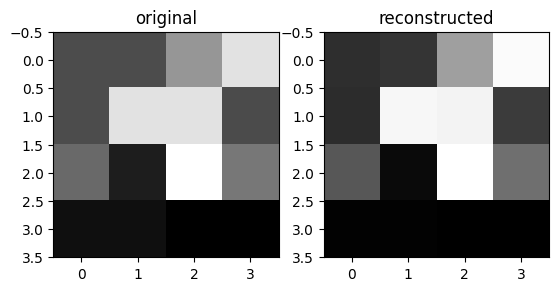

In [8]:
f = plt.figure()
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title("original")
ax.imshow(image, cmap='gray')

ax = f.add_subplot(gs[0, 1])
ax.set_title("reconstructed")
ax.imshow(retrived_image, cmap='gray')
